# Imports

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import umap

# User Configuration

In [ ]:
SAVE_FIG = True

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

RANDOM_SEED = 42

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

In [29]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine

In [ ]:
np.random.seed(RANDOM_SEED)

df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

## Daten zusammenführen

In [32]:
df_real['source']  = 'real'
df_synth['source'] = 'synthetic'
df_all = pd.concat([df_real, df_synth], ignore_index=True)

In [57]:
len(df_all)*(1-0.925)

14735.849999999991

## Spaltentypen erkennen

In [33]:
num_cols = df_all.select_dtypes(include=['number']).columns
cat_cols = df_all.select_dtypes(exclude=['number']).columns
cat_cols = [c for c in cat_cols if c != 'source']

## 10 % stratifizierte Sample-Indices

In [34]:
sample_idx, _ = train_test_split(
    np.arange(len(df_all)),
    test_size=0.9,
    stratify=df_all['source'],
    random_state=RANDOM_SEED
)
df_fit   = df_all.iloc[sample_idx]          # 10 % → fit
X_fit    = df_fit.drop(columns='source')
y_fit    = df_fit['source']

X_full   = df_all.drop(columns='source')    # 100 % → transform
y_full   = df_all['source']

df_fit   = df_all.iloc[sample_idx]          # 10 % → fit
X_fit    = df_fit.drop(columns='source')
y_fit    = df_fit['source']

X_full   = df_all.drop(columns='source')    # 100 % → transform
y_full   = df_all['source']

## 4. Preprocessing + (optionale) Vor-SVD

In [ ]:
pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore',
                          sparse_output=True), cat_cols)
])

# # Bei sehr breitem One-Hot-Vektor (10⁴+ Features) hilft SVD.
# svd = TruncatedSVD(n_components=50, random_state=RNG_SEED)  # falls RAM ein Thema

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric='euclidean',
    random_state=RANDOM_SEED,
    # n_jobs=-1, # kann wegen gesetztem random_state aus Gründen der Reproduzierbarkeit nicht gesetzt werden
)

pipe = Pipeline([
    ('prep', pre),
    # ('svd', svd), 
    ('umap', umap_model)
])

## 5. Fit auf 10 %

In [ ]:
# Laufzeit: 40 s
embedding_fit = pipe.fit_transform(X_fit)

c:\Masterarbeit\thesis\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Masterarbeit\thesis\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 6. Transformiere alle 100 %

In [ ]:
# Laufzeit: 1m 30s
embedding_full = pipe.transform(X_full)     # nur linearer Rechenschritt

c:\Masterarbeit\thesis\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 7. Plot-Stichprobe (≈ 15_000 Punkte)

In [38]:
plot_idx, _ = train_test_split(
    np.arange(len(df_all)),
    test_size=0.925,
    stratify=df_all['source'],
    random_state=RANDOM_SEED
)
emb_plot = embedding_full[plot_idx]
src_plot = y_full.iloc[plot_idx]

##  8. Visualisierung

In [ ]:
palette_cb = sns.color_palette("colorblind", 2)

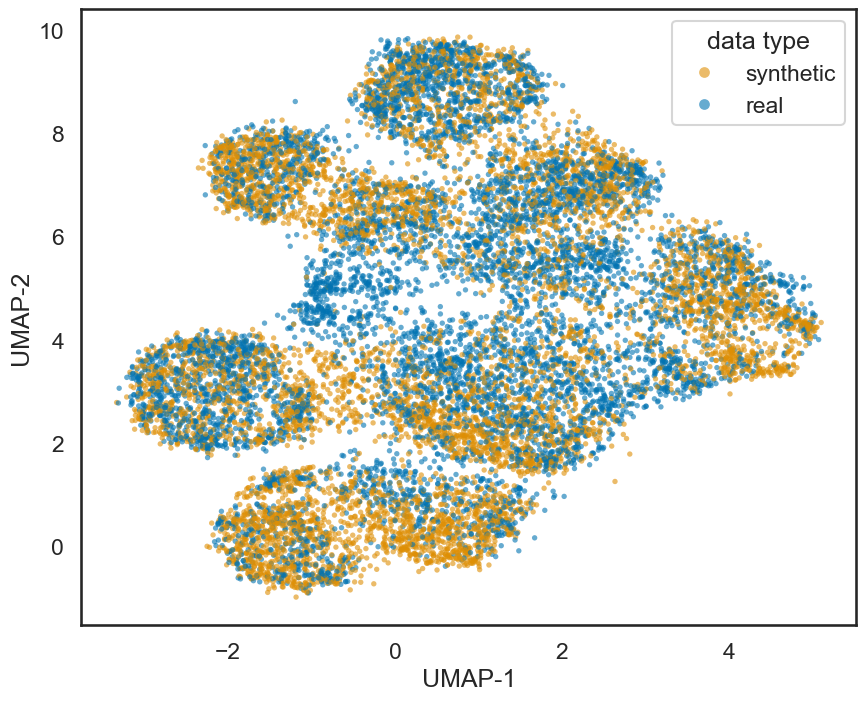

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x=emb_plot[:,0], y=emb_plot[:,1],
                hue=src_plot,
                palette={'real':palette_cb[0], 'synthetic':palette_cb[1]},
                alpha=0.6, s=15, linewidth=0)
plt.legend(title='data type', markerscale=2)
plt.title('Real & Synthetic Data')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"UMAP_both_10-fit_100-transform.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

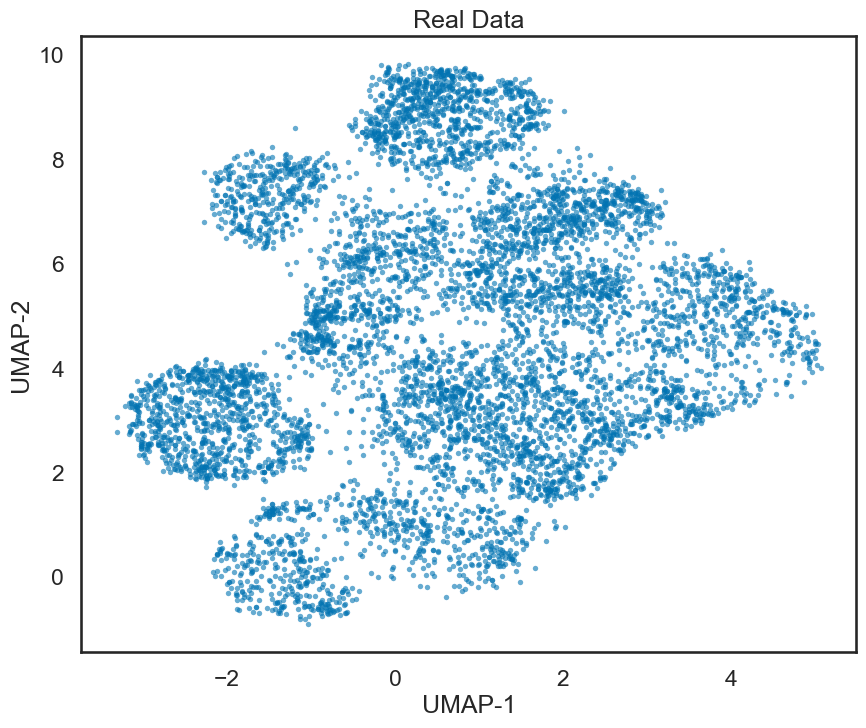

In [64]:
mask_real = src_plot == 'real'

fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x=emb_plot[mask_real, 0], y=emb_plot[mask_real, 1],
                color=palette_cb[0],
                alpha=0.6, s=15, linewidth=0)
plt.title('Real Data')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"UMAP_real_10-fit_100-transform.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)


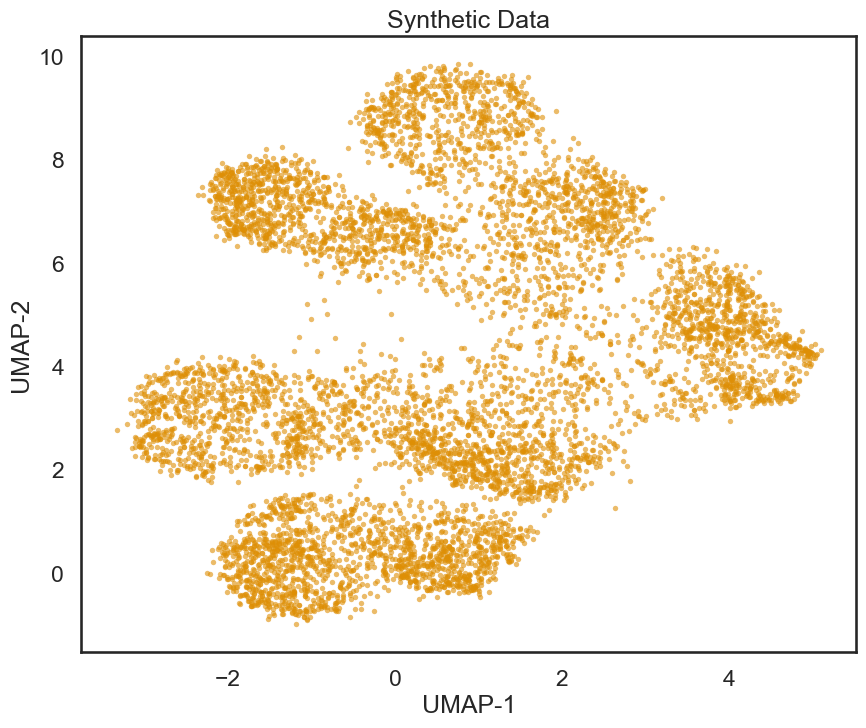

In [65]:
mask_real = src_plot == 'synthetic'

fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x=emb_plot[mask_real, 0], y=emb_plot[mask_real, 1],
                color=palette_cb[1],
                alpha=0.6, s=15, linewidth=0)
plt.title('Synthetic Data')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"UMAP_synth_10-fit_100-transform.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)
